In [4]:
import sys
sys.path.insert(0, '../')

# feature_extraction pipeline

This notebook explains how to extract features from the preprocessed data (from `make_dataset.py`). It explains each step along the way and gives an overview of how the pipeline works, as well as how it can be implemented in code. 

#### ***Quick start***

If you are only interested in extracting the features using default parameters (i.e. MultiRocket and Hydra), and all signals, you can do so by calling

`python src/data/feature_extraction.py --all_cols`

This will extract all features and save them in `data/processed/features.hdf5`.

The structure of the `features.hdf5` file will be as illustrated below. It is split into three data types, `train`, `val`, and `test`. The training and validation data has been generated using cross-validation, and there will thus be 5 folds (from 0 to 4). Each fold consists of segments, and each segment consists of the seconds belonging to that segment. Within these seconds the features from the feature extractors will be stored alongside the kpis from the preprocessed data. Next to the segments the statistics used for standardization during training are stored, for each fold. 

The tree below has been generated by calling `python src/data/check_hdf5.py`.

>features.hdf5<br>
│── train<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── fold_0<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── segments<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── segment_nr [int]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── second_nr [int]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── HydraMV_8_64 (5120,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── MultiRocketMV_50000 (49728,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── kpis<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── 1 (4,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── 2 (4,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\cdots$<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\cdots$<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── statistics<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── HydraMV_8_64<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── max (5120,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── mean (5120,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── min (5120,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── std (5120,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── used_cols (24,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── MultiRocketMV_50000<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── max (49728,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── mean (49728,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── min (49728,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── std (49728,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── used_cols (24,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── kpis<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── 1<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── max (4,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── mean (4,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── min (4,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── std (4,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── 2<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── max (4,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── mean (4,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── min (4,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── std (4,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── $\cdots$<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── fold_4<br>
│── val<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── fold_0<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── segments<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── segment_nr [int]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── second_nr [int]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── $\cdots$<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\cdots$<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\cdots$<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── $\cdots$<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── fold_4<br>
└── test<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── segments<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── segment_nr [int]<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── second_nr [int]<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── HydraMV_8_64 (5120,)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── MultiRocketMV_50000 (49728,)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── kpis<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── 1 (4,)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── 2 (4,)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\cdots$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\cdots$<br>

# Step 1 - Creating the datasets and dataloaders

**File:** `src/data/dataloader.py`

In the dataloader.py file, the Platoon dataset is defined. This dataset can be used to easily load the preprocessed data. It is a standard torch dataset, meaning it works by iterating over the data via `__getitem__`. In order for this to be possible, we store all indices for the given dataset as part of the Platoon class, and then we take the segment and second given the id of the data sample to fetch.

Let us create a dataset over the training data, with the acceleration in the x, y, and z directions, and plot the distribution of the data.

**Code in notebook:**

Arguments: 
                     Data Path:          ../data/processed/w_kpis/segments.hdf5
                     Train data Columns: ['acc.xyz_0', 'acc.xyz_1', 'acc.xyz_2'] 
                     KPI:           
                         - Names:        ['DI', 'RUT', 'PI', 'IRI'] 
                         - Window Size:  2 
                     Selected RUT:       straight-edge 
                     
Arguments: 
                     Data Path:          ../data/processed/w_kpis/segments.hdf5
                     Train data Columns: ['acc.xyz_0', 'acc.xyz_1', 'acc.xyz_2'] 
                     KPI:           
                         - Names:        ['DI', 'RUT', 'PI', 'IRI'] 
                         - Window Size:  2 
                     Selected RUT:       straight-edge 
                     


100%|██████████| 8188/8188 [01:15<00:00, 108.72it/s]


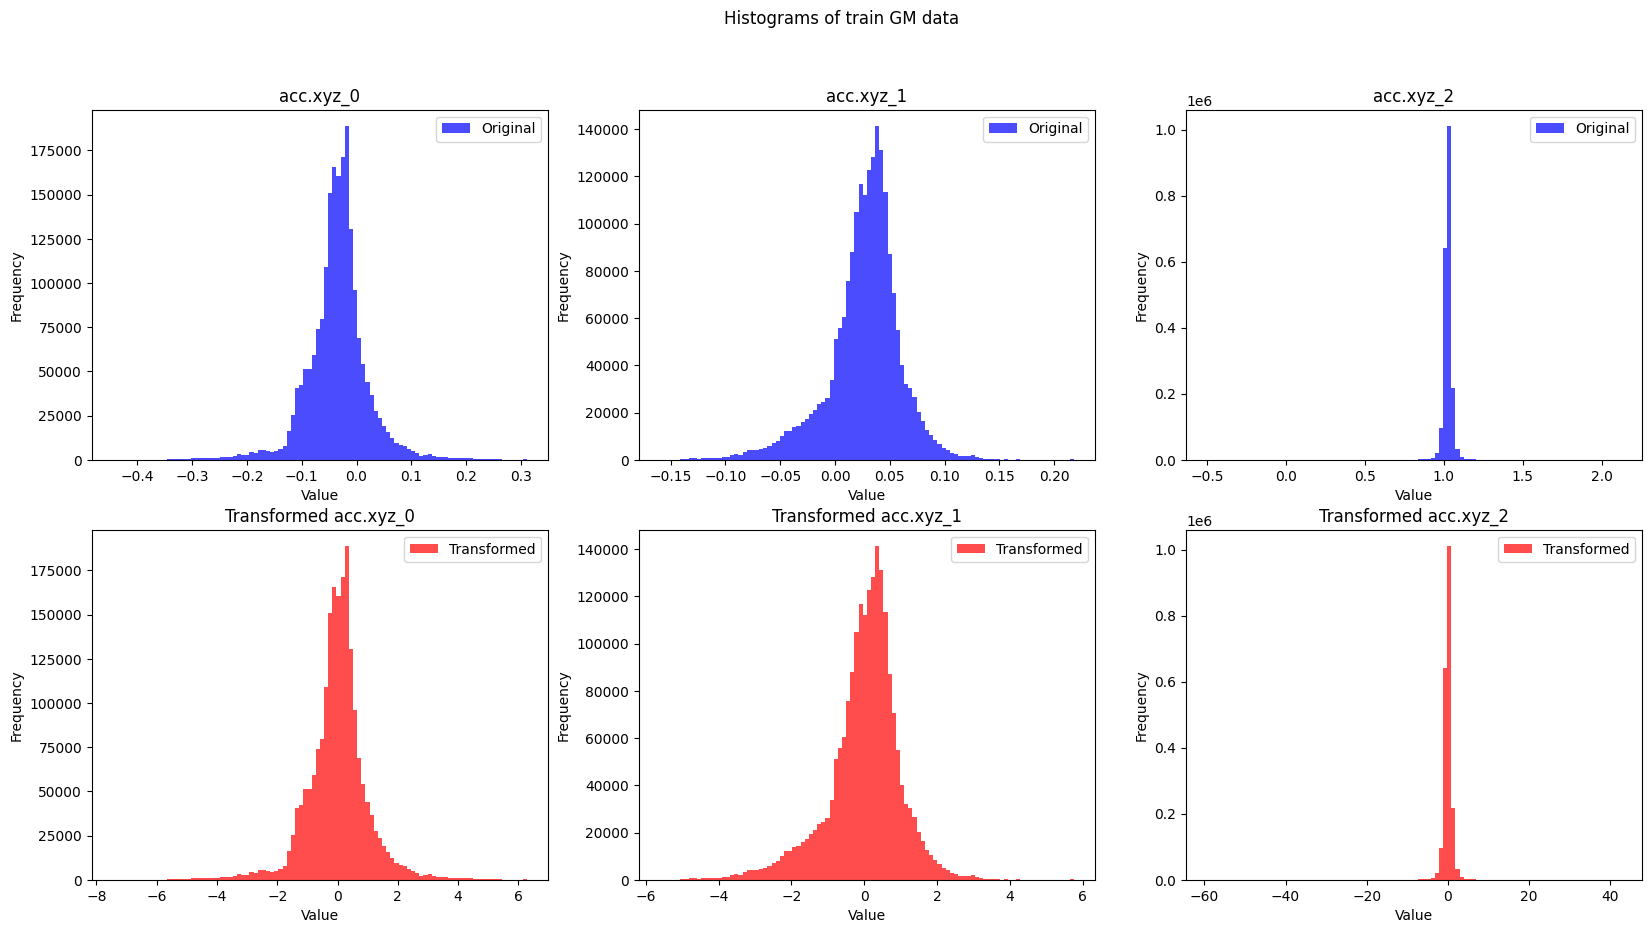

100%|██████████| 1446/1446 [00:03<00:00, 381.06it/s]


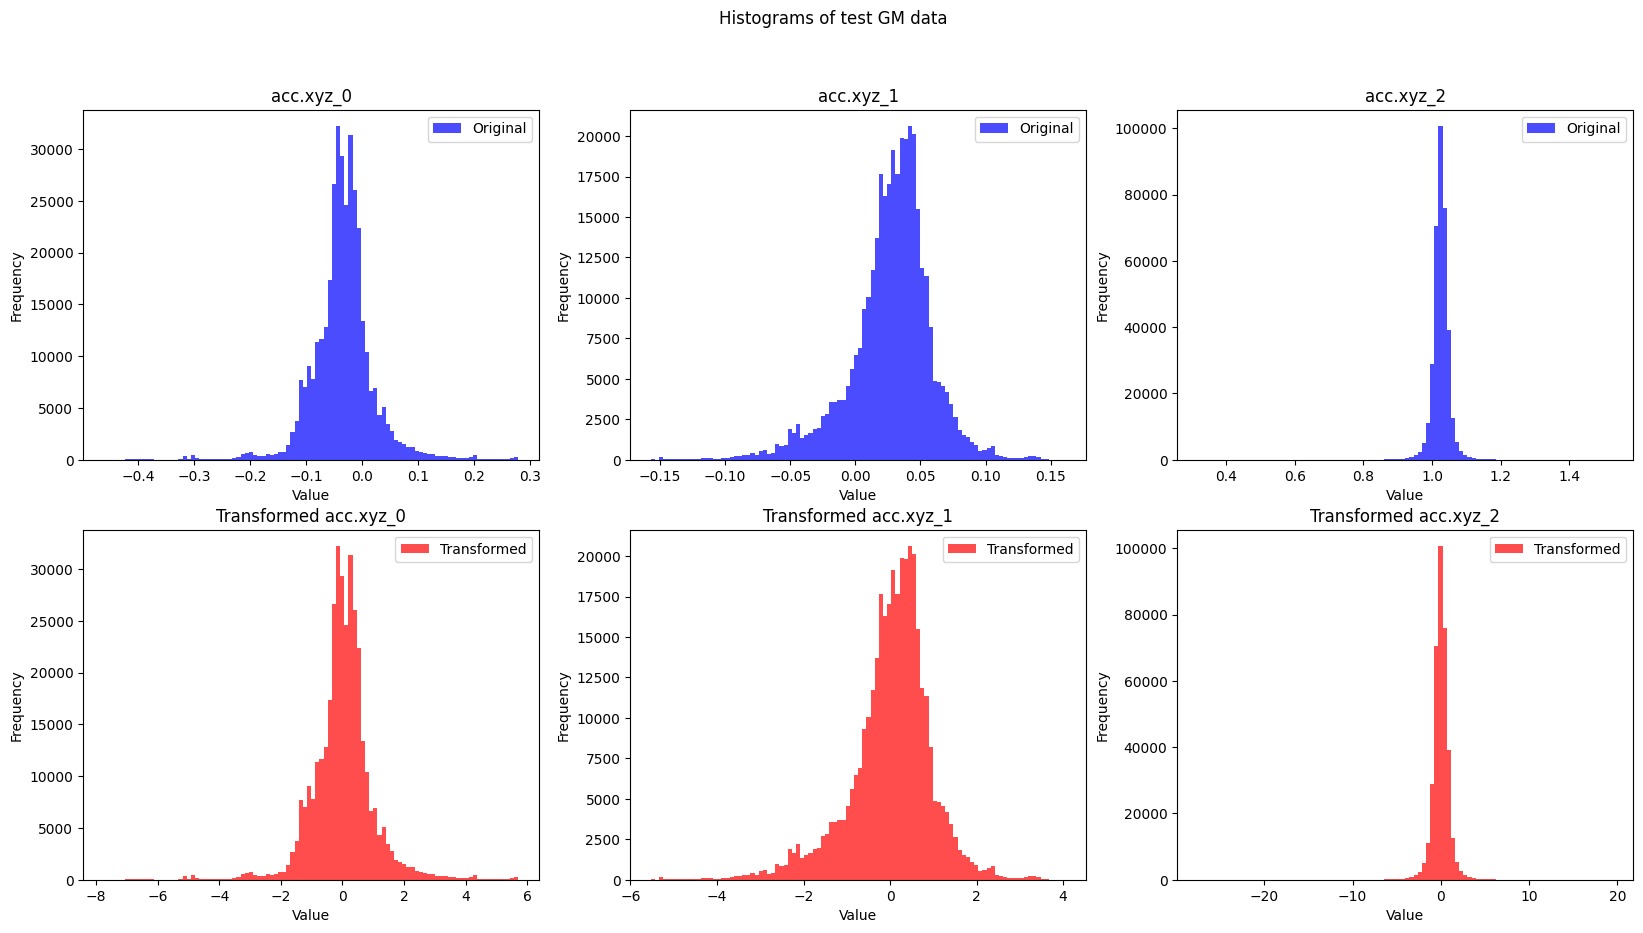

In [8]:
from src.data.dataloader import Platoon

# Create the dataset
trainset = Platoon(data_path='../data/processed/w_kpis/segments.hdf5', 
                  data_type='train', 
                  gm_cols=['acc.xyz_0', 'acc.xyz_1', 'acc.xyz_2'], 
                  pm_windowsize=2,
                  feature_extraction=True)

testset = Platoon(data_path='../data/processed/w_kpis/segments.hdf5', 
                  data_type='test', 
                  gm_cols=['acc.xyz_0', 'acc.xyz_1', 'acc.xyz_2'], 
                  pm_windowsize=2,
                  feature_extraction=True)

# Plot the dataset
trainset.plot_data()
testset.plot_data()

# Step 2 - Extracting features

**File:** `src/data/feature_extraction.py`

**Command** `python src/data/feature_extraction`

Arguments:

>--seed 42
>--cols acc.xyz_0 acc.xyz_1 acc.xyz_2
>--all_cols
>--mr_num_features 50000
>--hydra_input_length 250
>--subset None
>--name_identifier
>--folds 5


Now, it is time to begin extracting features. For ease of use, we will create new dataloaders here. This code is the same as in the main function of the feature_extraction file. There, several arguments have been added for ease of use. We will define them as variables at the top of the script.

To start with, we import several libraries, including the feature extractors. They are Hydra and MultiRocket, and can be found in `src/models/hydra` and `src/models/multirocket` respectively. They each have a univariate and multivariate variant.

In `feature_extraction.py`, several functions are implemented to extract features from all desired feature extractors. It is meant to be called via command line, but a demonstration is provided below.

**Code in notebook:**
> **NOTE:** Feature extraction takes ~20 minutes for MultiRocket and ~3 minutes for Hydra for each fold. Expect the total feature extraction time to be ~110 minutes with 5 folds.

In [11]:
# Import necessary libraries
import h5py
import torch
import numpy as np

from torch.utils.data import DataLoader
from sklearn.model_selection import KFold

from src.data.dataloader import Platoon
from src.util.utils import set_all_seeds
from src.models.hydra.hydra import Hydra
from src.models.multirocket.multirocket import MultiRocket
from src.models.hydra.hydra_multivariate import HydraMultivariate
from src.models.multirocket.multirocket_multivariate import MultiRocketMultivariate
from src.data.feature_extraction import extract_all_train_features, extract_all_test_features

In [12]:
# Variables that can be set via arguments
seed = 42
cols = ['acc_xyz_0', 'acc_xyz_1', 'acc_xyz_2']
all_cols = False
mr_num_features = 50000
hydra_input_length = 250
subset = None
name_identifier = ''
folds = 5

To be able to do KFold cross validation, we create a SubsetSampler, that is used in our dataloader.

In [13]:
class SubsetSampler(torch.utils.data.Sampler):
    """Samples elements from the given indices sequentially, always in the same order.
    
    Parameters:
    ----------
        indices (list): A list of indices to sample from
    """
    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return iter(self.indices)

    def __len__(self):
        return len(self.indices)

And now, for the feature extraction.

In [ ]:
# Set seed for reproducibility
set_all_seeds(seed)

# If all_cols is selected, then use all columns
if all_cols:
    cols = ['gps_0', 'gps_1',                                               # Latitute and longitude
            'acc.xyz_0', 'acc.xyz_1', 'acc.xyz_2',                          # Acceleration in x, y, z
            'spd_veh',                                                      # Vehicle speed
            'odo',                                                          # Odometer
            'acc_long', 'acc_trans', 'acc_yaw',                             # Longitudinal, transversal, and yaw acceleration
            'strg_acc', 'strg_pos',                                         # Steering acceleration and position
            'rpm', 'rpm_fl', 'rpm_fr', 'rpm_rl', 'rpm_rr',                  # RPM for each wheel
            'whl_prs_fl', 'whl_prs_fr', 'whl_prs_rl', 'whl_prs_rr',         # Wheel tire pressure for each wheel
            'whl_trq_est',                                                  # Estimated wheel torque                          
            'trac_cons',                                                    # Traction power
            'brk_trq_elec',                                                 # Brake torque
            ]

# Load the data
data_path = '../data/processed/w_kpis/segments.hdf5'
print(f'Loading data from {data_path}...')
trainset = Platoon(data_path=data_path,
                     data_type='train',
                     gm_cols=cols,
                     pm_windowsize=2,
                     feature_extraction=True
                     )

# Create feature extractors
# If only one column is selected, then use the univariate transformer
# If multiple columns are selected, then use the multivariate transformer
if len(cols) == 1:
    multi_rocket_transformer = MultiRocket(num_features=mr_num_features)
    hydra_transformer = Hydra(input_length=hydra_input_length)
else:
    multi_rocket_transformer = MultiRocketMultivariate(num_features=mr_num_features)
    hydra_transformer = HydraMultivariate(input_length=hydra_input_length, num_features=len(cols))

# Extract features
print(f"Extracting features from {multi_rocket_transformer.name} and {hydra_transformer.name}")

# Split training into K folds of training and validation data
kfold = KFold(n_splits=folds, shuffle=True, random_state=seed)
for fold, (train_idx, val_idx) in enumerate(kfold.split(trainset)):
    # Create dataloaders
    # NOTE: Must use batch_size=1, to avoid errors when loading the data
    trainloader = DataLoader(trainset, batch_size=1, sampler=SubsetSampler(train_idx))
    valloader = DataLoader(trainset, batch_size=1, sampler=SubsetSampler(val_idx))
    
    # Extract features from train and val data for each fold
    with h5py.File(data_path, 'r') as f:
        print(f"Extracting features for fold {fold+1}/{folds}")
        extract_all_train_features(feature_extractors=[multi_rocket_transformer, hydra_transformer], 
                                   data_loaders=[trainloader, valloader], 
                                   segment_file=f, 
                                   fold=fold, 
                                   calculate_statistics=[True, False])
        

# Load the test data
print(f'Loading test data from {data_path}...')
testset = Platoon(data_path=data_path,
                     data_type='test',
                     gm_cols=cols,
                     pm_windowsize=2,
                     feature_extraction=True)
testloader = DataLoader(testset, batch_size=1)

print(f"Extracting features for test data...")
with h5py.File(data_path, 'r') as f:
    extract_all_test_features(feature_extractors=[multi_rocket_transformer, hydra_transformer], 
                              data_loader=[testloader], 
                              segment_file=f, 
                              )
    
print("Feature extraction complete!")

# Step 3 - Inspecting the features

**File:** `src/data/check_hdf5.py`

We can now inspect the `features.hdf5` file we have created. By calling

`python src/data/check_hdf5 --limit 3 --summary` 

a tree of the file structure will be printed, along with a summary of the statistics and amount of stored features. 

**Code in notebook:**

In [14]:
from src.data.check_hdf5 import h5_tree, summary

file_path = '../data/processed/features.hdf5'
limit = 3
print_summary = True

# Print the tree structure
print('\n    ---### HDF5 FILE STRUCTURE ###---\n')
h5_tree(val=h5py.File(file_path, 'r'), max_items=3)

if print_summary:
    summary(file_path)


    ---### HDF5 FILE STRUCTURE ###---

├── test
│   └── segments
│       ├── 0
│       │   ├── 10
│       │   │     ├──   Hydra_8_64   (5120,)
│       │   │     ├──   MultiRocket_50000   (49728,)
│       │   │   └── kpis
│       │   │         ├──   1   (4,)
│       │   │         └──   2   (4,)
│       │   ├── 13
│       │   │     ├──   Hydra_8_64   (5120,)
│       │   │     ├──   MultiRocket_50000   (49728,)
│       │   │   └── kpis
│       │   │         ├──   1   (4,)
│       │   │         └──   2   (4,)
│       │   ├── 2
│       │   │     ├──   Hydra_8_64   (5120,)
│       │   │     ├──   MultiRocket_50000   (49728,)
│       │   │   └── kpis
│       │   │         ├──   1   (4,)
│       │   │         └──   2   (4,)
│       │   ⋮
│       ├── 1
│       │   ├── 12
│       │   │     ├──   Hydra_8_64   (5120,)
│       │   │     ├──   MultiRocket_50000   (49728,)
│       │   │   └── kpis
│       │   │         ├──   1   (4,)
│       │   │         └──   2   (4,)
│       │   ├── 18
│       │ 